In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Load Data
First we load the data from the directory 'Data.nosync+'. We create a dataframe containing all data and provide column names.

In [20]:
# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names
# read data
directory = '../Data.nosync+/'
files = ['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']
dataframes = []
for index, data in enumerate(files):
    file_path = os.path.join(directory, data)
    df = pd.read_csv(file_path, sep='\s+', header=None, names=col_names)
    df['unit_nr']=df['unit_nr'].apply(lambda x: str(index) + '_' + str(x))
    dataframes.append(df)
train = pd.concat(dataframes, ignore_index=True)

In [21]:
train

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,0_1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,0_1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,0_1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,0_1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,0_1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,3_249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,380.16,2388.73,8185.69,8.4541,0.03,372,2319,100.0,29.11,17.5234
160355,3_249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,535.02,2388.46,8185.47,8.2221,0.03,396,2388,100.0,39.38,23.7151
160356,3_249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,535.41,2388.48,8193.94,8.2525,0.03,395,2388,100.0,39.78,23.8270
160357,3_249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,187.92,2388.83,8125.64,9.0515,0.02,337,2223,100.0,15.26,9.0774


# Preprocessing
Initially we normalize the sensor data. We then add a column containing the RUL value based on cycles. Said RUL is calculated by the difference between max cycle and current cycle for each unit individually.

### Functions

In [22]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_scale = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_15', 's_17', 's_20', 's_21', 's_1', 's_5', 's_6', 's_10', 's_14', 's_16', 's_18', 's_19']
for column in columns_to_scale:
    train[column] = scaler.fit_transform(train[[column]])

In [42]:
# Remove those column as we can see that it's value is not changing#
#cols_to_drop = ['setting_3', 's_1', 's_5', 's_6', 's_10', 's_14', 's_16', 's_18', 's_19']
#train=train.drop(cols_to_drop, axis=1)

In [71]:
# Adding RUL (Remaining Useful Life) to the train dataset
train = add_remaining_useful_life(train)
#train[sensor_names+['RUL']].head()
train = train.fillna(method='ffill')
print(train.shape, "There are no NA values: ", (train.isna().sum()==0).all())

(160359, 27) There are no NA values:  True


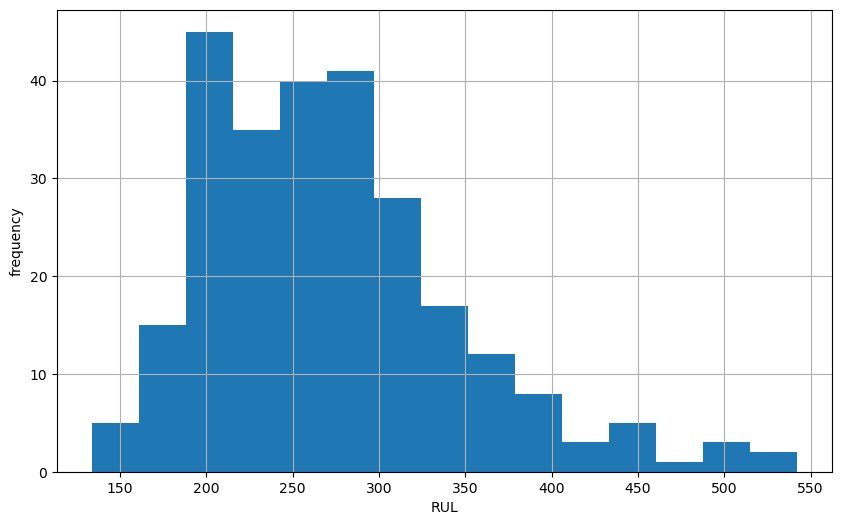

In [72]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(10,6))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

Add RUL Classes

In [73]:
train['RUL'].quantile([.1, .25, .5, .75, 0.9])

0.10     47.0
0.25     97.0
0.50    163.0
0.75    230.0
0.90    295.0
Name: RUL, dtype: float64

In [74]:
train['Class'] = pd.cut(x=train['RUL'], bins=[-1,51,103,155,361], labels=['Inception','Healthy','Mature','Attention_Required'])
print(train.shape)
train.Class.head()

(160359, 28)


0    Attention_Required
1    Attention_Required
2    Attention_Required
3    Attention_Required
4    Attention_Required
Name: Class, dtype: category
Categories (4, object): ['Inception' < 'Healthy' < 'Mature' < 'Attention_Required']

# Train Model

In [75]:
from sklearn.model_selection import train_test_split

# Splitting of Independent & Dependent Variable and train input and output data
X = train.drop(axis=0, columns=['Class','unit_nr','time_cycles','RUL'])
Y = train.Class
# Split into training and test sets
X_train, X_validate, y_train, y_validate = train_test_split(X, Y, test_size=0.33, random_state=42)
y_train=y_train.astype('object')
print(X_train.shape, X_validate.shape)
y_train.tail()

(107440, 24) (52919, 24)


55013     Attention_Required
47408                Healthy
146141                   NaN
154268    Attention_Required
140451    Attention_Required
Name: Class, dtype: object

In [76]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

num_of_classes = len(train.Class.unique())
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_validate = le.fit_transform(y_validate)
print(y_train, y_validate)


[3 0 3 ... 4 0 0] [3 0 3 ... 0 0 0]


RandomForestClassifier()

In [86]:
X_temp = train.drop(columns=['RUL', 'Class'])
X_temp

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,1.000000,0.969990,0.927293,0.902111,1.000000,...,0.961313,0.993194,0.653748,0.090428,1.0,0.918367,1.000000,1.0,0.972082,0.970373
1,1,2,0.0019,-0.0003,100.0,1.000000,0.973000,0.932957,0.908192,1.000000,...,0.962828,0.993332,0.637831,0.094654,1.0,0.918367,1.000000,1.0,0.970064,0.970630
2,1,3,-0.0043,0.0003,100.0,1.000000,0.974824,0.922723,0.910730,1.000000,...,0.963170,0.993222,0.641715,0.089844,1.0,0.897959,1.000000,1.0,0.968382,0.966204
3,1,4,0.0007,0.0000,100.0,1.000000,0.974824,0.908829,0.905152,1.000000,...,0.964246,0.993359,0.643055,0.072803,1.0,0.918367,1.000000,1.0,0.966028,0.967860
4,1,5,-0.0019,-0.0002,100.0,1.000000,0.975007,0.908989,0.915565,1.000000,...,0.962608,0.993249,0.642988,0.093829,1.0,0.928571,1.000000,1.0,0.966700,0.969560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74385,260,312,20.0037,0.7000,100.0,0.626985,0.668704,0.675850,0.588289,0.507937,...,0.453932,0.995950,0.722999,0.394146,1.0,0.683673,0.864693,1.0,0.477632,0.474270
74386,260,313,10.0022,0.2510,100.0,0.597937,0.641521,0.725871,0.719022,0.617180,...,0.593651,0.994296,0.892039,0.206933,1.0,0.734694,0.854123,1.0,0.603431,0.609526
74387,260,314,25.0041,0.6200,60.0,0.238089,0.018243,0.089702,0.081753,0.293184,...,0.086588,0.007605,0.280104,0.999588,0.0,0.081633,0.000000,0.0,0.135553,0.141572
74388,260,315,25.0033,0.6220,60.0,0.238089,0.021527,0.080911,0.101815,0.293184,...,0.088127,0.007660,0.282828,0.995465,0.0,0.091837,0.000000,0.0,0.130844,0.131683


In [ ]:
from tsfresh import extract_relevant_features, extract_features

X_temp_feat = extract_features(X_temp, column_id='unit_nr', column_sort='time_cycles')

Feature Extraction:   0%|          | 0/20 [00:00<?, ?it/s]

,Class,unit_nr
0,Attention_Required,1
1,Attention_Required,1
2,Attention_Required,1
3,Attention_Required,1
4,Attention_Required,1
...,...,...
74385,Inception,260
74386,Inception,260
74387,Inception,260
74388,Inception,260


In [ ]:
rf = RandomForestClassifier()
rf.fit(X=X_train, y=y_train)

In [77]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from sklearn import preprocessing

def evaluation(model, X, y, set="train"):
    y_hat = model.predict(X)
    lb = preprocessing.LabelBinarizer()
    y_lb = lb.fit_transform(y)
    y_hat_lb = lb.transform(y_hat)
    #print(y_lb, y_hat_lb)
    print(f"roc score for {set} dataset: ", roc_auc_score(y_lb, y_hat_lb, average='macro'))
    print(f'Acc Score for {set} dataset: ', accuracy_score(y_lb, y_hat_lb))
    print(f'Precision Score for {set} dataset: ', precision_score(y_lb, y_hat_lb, average='macro'))
    print(f'Recall Score for {set} dataset: ', recall_score(y_lb, y_hat_lb, average='macro'))
    print(f'f1 score for {set} dataset: ', f1_score(y_lb, y_hat_lb, average='macro'))

In [78]:
X_train.describe()

,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,107440.000000,107440.000000,107440.000000,107440.000000,107440.000000,107440.000000,107440.000000,107440.000000,107440.000000,107440.000000,...,107440.000000,107440.000000,107440.000000,107440.000000,107440.000000,107440.000000,107440.000000,107440.000000,107440.000000,107440.000000
mean,17.183885,0.409344,95.703276,0.554828,0.564675,0.599619,0.568005,0.559346,0.549723,0.514775,...,0.514814,0.886934,0.542770,0.308728,0.519090,0.599053,0.758257,0.892582,0.531307,0.533045
std,16.517058,0.367745,12.385820,0.412710,0.387518,0.315981,0.326430,0.398063,0.404095,0.400556,...,0.401192,0.306977,0.180357,0.258682,0.499638,0.316753,0.301799,0.309646,0.393140,0.390920
min,-0.008700,-0.000600,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000598,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000673,0.000000
25%,0.001300,0.000200,100.000000,0.060269,0.132081,0.306461,0.246648,0.146592,0.146173,0.090972,...,0.089178,0.993056,0.501585,0.097231,0.000000,0.306122,0.627907,1.000000,0.140262,0.144426
50%,19.998000,0.620000,100.000000,0.597937,0.642342,0.668715,0.600689,0.507937,0.501255,0.476521,...,0.476428,0.993332,0.609390,0.290713,1.000000,0.663265,0.854123,1.000000,0.499495,0.501580
75%,35.001500,0.840000,100.000000,1.000000,0.974824,0.919089,0.905966,1.000000,1.000000,0.959691,...,0.960531,0.993580,0.655534,0.408095,1.000000,0.918367,1.000000,1.000000,0.964009,0.963406
max,42.008000,0.842000,100.000000,1.000000,1.000000,1.000000,0.998276,1.000000,1.000000,1.000000,...,1.000000,0.999972,1.000000,0.999794,1.000000,1.000000,1.000000,1.000000,1.000000,0.998071


In [79]:
X_train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107440 entries, 118165 to 140451
Data columns (total 24 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   setting_1  107440 non-null  float64
 1   setting_2  107440 non-null  float64
 2   setting_3  107440 non-null  float64
 3   s_1        107440 non-null  float64
 4   s_2        107440 non-null  float64
 5   s_3        107440 non-null  float64
 6   s_4        107440 non-null  float64
 7   s_5        107440 non-null  float64
 8   s_6        107440 non-null  float64
 9   s_7        107440 non-null  float64
 10  s_8        107440 non-null  float64
 11  s_9        107440 non-null  float64
 12  s_10       107440 non-null  float64
 13  s_11       107440 non-null  float64
 14  s_12       107440 non-null  float64
 15  s_13       107440 non-null  float64
 16  s_14       107440 non-null  float64
 17  s_15       107440 non-null  float64
 18  s_16       107440 non-null  float64
 19  s_17       107440 

In [80]:
evaluation(rf, X_train, y_train, set='train')
evaluation(rf, X_validate, y_validate, set='validate')

roc score for train dataset:  0.9999720796005096
Acc Score for train dataset:  0.9999906924795234
Precision Score for train dataset:  0.9999962430025924
Recall Score for train dataset:  0.9999478487614081
f1 score for train dataset:  0.9999720424642234
roc score for validate dataset:  0.6463693310980491
Acc Score for validate dataset:  0.6036773181654982
Precision Score for validate dataset:  0.5247786642591854
Recall Score for validate dataset:  0.42270235423591707
f1 score for validate dataset:  0.39684373109773063


In [12]:
# Final Results in the form of dataset
output = pd.DataFrame()
output['Expected Output'] = y_validate
output['Predicted Output'] = rf.predict(X_validate)
output.tail()

,Expected Output,Predicted Output
6804,2,2
6805,1,2
6806,0,0
6807,0,0
6808,0,0


In [13]:
rf.predict_proba(X_validate)

array([[0.26, 0.29, 0.01, 0.44],
       [0.  , 0.  , 1.  , 0.  ],
       [0.63, 0.02, 0.  , 0.35],
       ...,
       [0.68, 0.07, 0.  , 0.25],
       [0.48, 0.13, 0.  , 0.39],
       [0.46, 0.2 , 0.  , 0.34]])

In [14]:
import joblib

joblib.dump(rf, "my_random_forest.joblib")

['my_random_forest.joblib']